# COGS 108 - EDA Checkpoint

# Names

- Sharon Chen
- Pamela Ghag
- Yuzi Chu
- Cheng Chang
- Stanley Hahm

<a id='research_question'></a>
# Research Question

Are there significant differences among courses under the Humanities, Social Sciences, and STEM departments at UCSD in terms of the correlation between course difficulty (as indicated through average GPA) and teachers’ ratings on the student-feedback platforms (CAPE)?

# Setup

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import patsy
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# The seaborn library makes plots look nicer
# sns.set(context = 'talk', style='white')

# Set font size for graph labels
sns.set(font_scale = 2)

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Make plots just slightly bigger for displaying well in notebook
# set plotting size parameter
plt.rcParams['figure.figsize'] = (10, 5)

In [76]:
# Read in data
cape = pd.read_csv("https://raw.githubusercontent.com/dcao/seascape/master/data/data.csv")

# Data Cleaning

Since we do not want any data that may be influenced by the COVID-19 pandemic, we want to __drop evaluations made for school term WI20 and SP20__, the lastest 2 terms recorded in the dataset.

In [77]:
cape = cape.drop(cape[(cape.term =='WI20') | (cape.term =='SP20')].index)
cape.head()

,instr,course,term,enrolled,evals,recClass,recInstr,hours,gpaExp,gpaAvg
0,"Butler, Elizabeth Annette",AAS 10,FA20,65,29,89.0,96.0,4.50,3.77,3.33
1,"Puritty, Chandler Elizabeth",AAS 190,FA20,19,5,100.0,100.0,2.10,4.00,NaN
2,"Andrews, Abigail Leslie",AIP 197T,FA20,34,11,100.0,100.0,4.06,3.67,NaN
3,"Jones, Ian William Nasser",ANAR 120,FA20,15,4,100.0,100.0,2.50,3.50,NaN
4,"Smith, Neil Gordon",ANAR 121,FA20,17,6,100.0,100.0,6.50,4.00,NaN


In [78]:
cape.dtypes

instr        object
course       object
term         object
enrolled      int64
evals         int64
recClass    float64
recInstr    float64
hours       float64
gpaExp      float64
gpaAvg      float64
dtype: object

__Data types__ seems to be what we want.

An important method for us to estimate the difficulty of the courses is the average GPA received by the students; therefore, data with no "gpaAvg" does not seem helpful for our purposes. We want to __drop all rows with NaN in the column of average GPA__.

In [79]:
cape = cape.dropna(subset=['gpaAvg'])

Next, we __change column names__ so they are more similar and "pythonic".

In [80]:
col_name_map = {
    "evals": "eval",
    "recClass": "rec_class",
    "recInstr": "rec_instr",
    "gpaExp": "gpa_exp",
    "gpaAvg": "gpa_rec"
}
cape = cape.rename(columns=col_name_map)
print(list(cape.columns))

['instr', 'course', 'term', 'enrolled', 'eval', 'rec_class', 'rec_instr', 'hours', 'gpa_exp', 'gpa_rec']


As stated above, due to privacy concern, we would like to hide the name of the instructor and the course. Here we will first __map insturctor names to an ID and delete their names from the DataFrame__.

In [81]:
# Change all instructor names to lower cases
cape["instr"] = cape["instr"].apply(lambda name: name.lower())

# Make a list of unique instructor name and IDs
instr_names = cape["instr"].unique()
instr_names.sort()
instr_ids = [("I_" + str(x)) for x in range(len(instr_names))]

# Make a map of names and IDs
instr_id_map = {n:i for (n,i) in zip(instr_names, instr_ids)}

# Switch instructor names to IDs
cape["instr"] = cape["instr"].apply(lambda name: instr_id_map[name])

# Reset DataFrame index
cape = cape.reset_index(drop=True)

We need to change course names to IDs as we need to __classify the disciplines (Humanities, Social Science, STEM) they belongs to__, and __hide class names for privacy__.

In [82]:
# takes out number in class course name so only class department
def class_department(str_in):
    # takes out number
    class_dep = re.sub(r'\d+', '', str_in)
    
    # takes out any extra letter. I.e. 'CHEM A' --> 'CHEM'
    class_dep_split = class_dep.split()
    class_dep = class_dep_split[0]
    return class_dep

# use class_department to change all courses to fit only department
cape['course'] = cape['course'].apply(class_department)

__Separate these majors into `stem`, `social_sci`, and `hum` fields.__

Note and disclaimer: When classifying courses, we try our best to rely upon their respective majors and departments; however, some outliers are hand-picked. We understand that this decision may cause biases in our result. Notably:
- 'ERC' and 'TMC' are discarded as college seminars.
- 'ESYS' and 'ENVR' are classified as social science, as they touch heavily on environmental policy and soical decisions.
- All college writing courses are classified as humanities.

In [83]:
#SOME OF THESE MAJORS HAVE DIFFERENT DEPARTMENT NAMES BUT SAME MAJOR
#ex: Anthroplogy = 'ANAR', 'ANBI', 'ANSC', 'ANTH'

#list of STEM majors
stem = ['BENG', 'BIBC', 'BICD', 'BIEB', 'BILD', 'BIMM', 'BIPN', 
        'BISP', 'CENG', 'CHEM', 'CHIN', 'CSE', 'DSC', 'ECE', 
        'FMPH', 'GLBH', 'HDS', 'MAE', 'MATH', 'NANO', 'PHYS',
        'SE', 'SIO', 'FPMU']

#list of social science majors
social_sci = ['ANAR', 'ANBI', 'ANSC', 'ANTH', 'CGS', 'COGS', 
              'CSS', 'DSGN', 'ECON', 'EDS', 'ENVR', 'ETHN',
              'ESYS', 'HIAF', 'HIEA', 'HIEU','HILA', 'HILD',
              'HINE', 'HISC', 'HITO', 'HIUS', 'INTL', 'MGT',
              'POLI', 'PSYC', 'SOCI', 'TWS', 'USP', 'CCS',
              'HDP', 'LAWS', 'HMNR', 'COGN', 'SOCE', 'STPA',
              'SOCA', 'SOCB', 'SOCC', 'SOCD','SOCL']

#list of humanities majors
hum = ['AAS', 'AWP', 'CAT', 'COMM', 'DOC', 'ENG', 'HUM', 'JAPN', 
       'LATI', 'LIGN', 'LTAM', 'LTCH', 'LTCS', 'LTEA', 'LTEN', 
       'LTEU', 'LTFR', 'LTGM', 'LTLA', 'LTRU', 'LTSP', 'LTTH', 
       'LTWL', 'LTWR', 'MMW', 'MUS', 'PHIL', 'RELI', 'TDAC', 'TDDE',
       'TDDM', 'TDDR', 'TDGE', 'TDHT', 'TDMV', 'TDPR', 'TDTR', 'VIS',
       'WCWP', 'LIHL', 'LTGK', 'LTIT', 'LTKO', 'TDPW', 'TDPF',
       'ELWR', 'ICAM', 'TDHD', 'JUDA', 'COCU', 'COHI', 'COMT', 'COSF', 
       'TDCH', 'LTAF']

In [84]:
# Make new column for determining field of study
def set_field(course):
    if course in stem:
        return "stem"
    elif course in social_sci:
        return "social_sci"
    elif course in hum:
        return "hum"
    return np.nan

cape["field"] = cape["course"].apply(set_field)

In [85]:
cape.dropna(subset=["field"], inplace=True)
print(cape.shape)
cape.head()

(34273, 11)


,instr,course,term,enrolled,eval,rec_class,rec_instr,hours,gpa_exp,gpa_rec,field
0,I_457,AAS,FA20,65,29,89.0,96.0,4.50,3.77,3.33,hum
1,I_758,ANAR,FA20,41,16,100.0,100.0,4.00,3.81,3.79,social_sci
2,I_1099,ANBI,FA20,20,15,93.0,100.0,2.77,3.67,3.77,social_sci
3,I_3175,ANBI,FA20,22,15,66.0,73.0,5.17,3.27,2.99,social_sci
4,I_1137,ANBI,FA20,117,53,100.0,100.0,3.75,3.70,3.87,social_sci


# Data Analysis & Results (EDA)

In [86]:
cape.describe()

,enrolled,eval,rec_class,rec_instr,hours,gpa_exp,gpa_rec
count,34273.00,34273.00,34273.00,34273.00,34273.00,33931.00,34273.00
mean,100.04,51.11,87.31,87.20,5.80,3.46,3.23
std,91.58,51.61,12.22,14.85,2.35,0.29,0.40
min,20.00,3.00,0.00,0.00,0.50,1.60,1.21
25%,34.00,16.00,81.00,82.00,4.23,3.27,2.93
50%,63.00,32.00,90.00,92.00,5.39,3.46,3.22
75%,138.00,68.00,97.00,99.00,6.94,3.67,3.52
max,1064.00,509.00,100.00,100.00,20.33,4.00,4.00


We see that some courses have very few evaluations. Check what those are and drop them.

In [87]:
print("Dropped courses with less than 5 evaluations:", len(cape[cape["eval"] < 5]))
cape = cape[cape["eval"] >= 5]

Dropped courses with less than 5 evaluations: 335


If the ratios between evaluation and enrolled are too small, we may not receive an accurate reflection of the overall student feedback. We want to look at the relation between these two values.

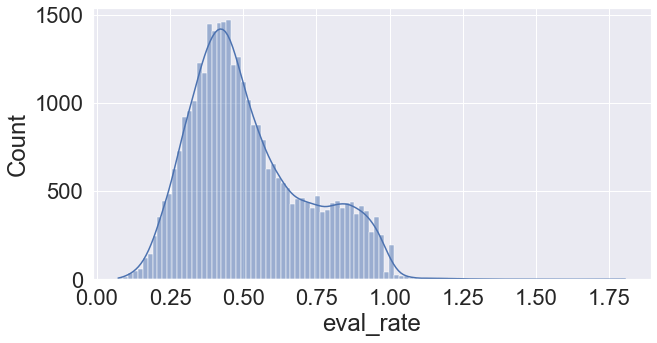

In [88]:
cape["eval_rate"] = cape["eval"] / cape["enrolled"]
plot_eval_rate = sns.histplot(cape["eval_rate"], kde=True)

In [89]:
print("Dropped courses with less than 20% evaluation rates:", len(cape[cape["eval_rate"] < 0.2]))
cape = cape[cape["eval_rate"] >= 0.2]

Dropped courses with less than 20% evaluation rates: 540


In [90]:
print(cape.shape)
cape.head()

(33398, 12)


,instr,course,term,enrolled,eval,rec_class,rec_instr,hours,gpa_exp,gpa_rec,field,eval_rate
0,I_457,AAS,FA20,65,29,89.0,96.0,4.50,3.77,3.33,hum,0.45
1,I_758,ANAR,FA20,41,16,100.0,100.0,4.00,3.81,3.79,social_sci,0.39
2,I_1099,ANBI,FA20,20,15,93.0,100.0,2.77,3.67,3.77,social_sci,0.75
3,I_3175,ANBI,FA20,22,15,66.0,73.0,5.17,3.27,2.99,social_sci,0.68
4,I_1137,ANBI,FA20,117,53,100.0,100.0,3.75,3.70,3.87,social_sci,0.45


In [91]:
cape.describe()

,enrolled,eval,rec_class,rec_instr,hours,gpa_exp,gpa_rec,eval_rate
count,33398.00,33398.00,33398.0,33398.00,33398.00,33071.00,33398.00,33398.00
mean,101.22,52.22,87.3,87.23,5.77,3.46,3.22,0.53
std,92.13,51.80,12.1,14.72,2.33,0.29,0.40,0.20
min,20.00,5.00,0.0,0.00,0.50,1.60,1.21,0.20
25%,34.00,17.00,81.0,82.00,4.22,3.27,2.93,0.38
50%,65.00,33.00,90.0,92.00,5.38,3.46,3.22,0.48
75%,140.00,69.00,96.0,98.00,6.90,3.67,3.51,0.65
max,1064.00,509.00,100.0,100.00,20.33,4.00,4.00,1.81


We now have a new `cape` dataset that also tells us what field of study these courses belongs to. We want to __separate them into 3 dataset__ and make scatterplot for them.

In [92]:
cape_stem = cape[cape['field'] == "stem"]
cape_social_sci = cape[cape['field'] == "social_sci"]
cape_hum = cape[cape['field'] == "hum"]

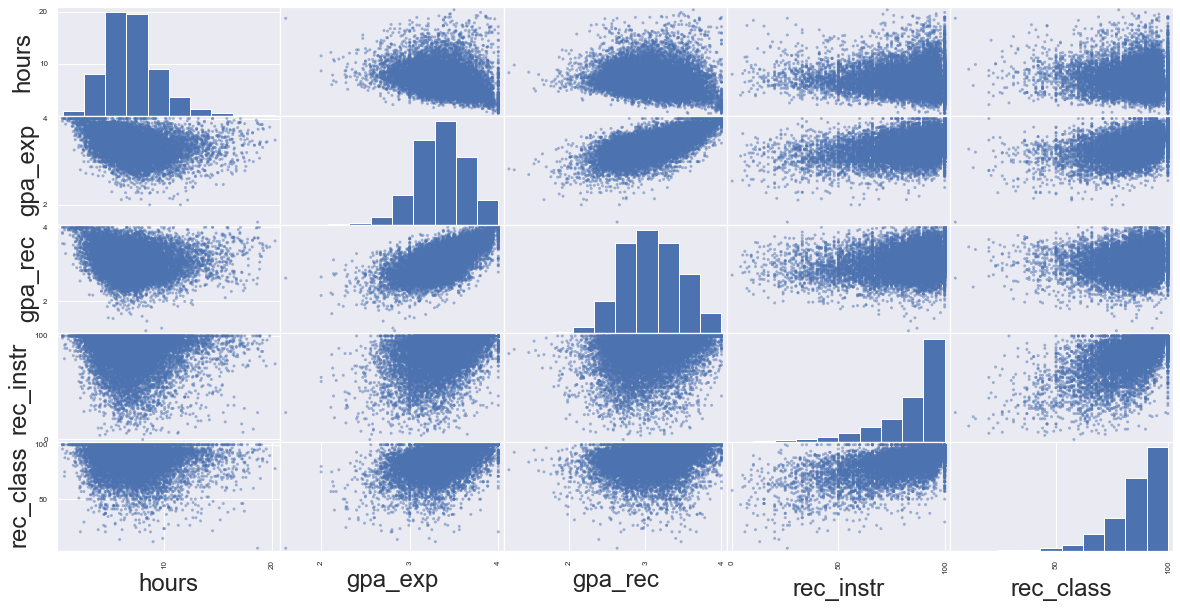

In [93]:
# generate a scatter matrix of stem professors
fig1 = pd.plotting.scatter_matrix(cape_stem[['hours','gpa_exp','gpa_rec','rec_instr','rec_class']], figsize=(20, 10))

In the above scattermatrix, we see that the histogram for gpa_rec-- (a variable that is pertinent to our research question through its representation of course difficulty)-- follows an approximately normal distribution. This indicates that the majority of data points are relatively similar, in that they occur within a small range of values, with few outliers on the high and low ends (i.e. there were neither abnormally high average GPAs nor abnormally low ones). On the other hand, the histogram for rec_instr-- (a variable that is pertinent to our research question through its representation of students' perceptions of professors)-- is heavily skewed left, possibly indicating that students were more likely to give higher teacher recommendations as opposed to lower. This idea is further shown in the scatterplot depicting the relationship between gpa_rec (on the x-axis) and rec_instr (on the y-axis), whereby a larger density of points can be found situated in the topmost (higher) side of the plot, indicating typically higher recommendation values for a range of class GPAs. We will explore this relationship further to gain a more nuanced analysis of exactly how strong (or weak) this relationship between class GPA and teacher recommendation percentages is for STEM classes in comparison to those within the Social Science and Humanities departments.

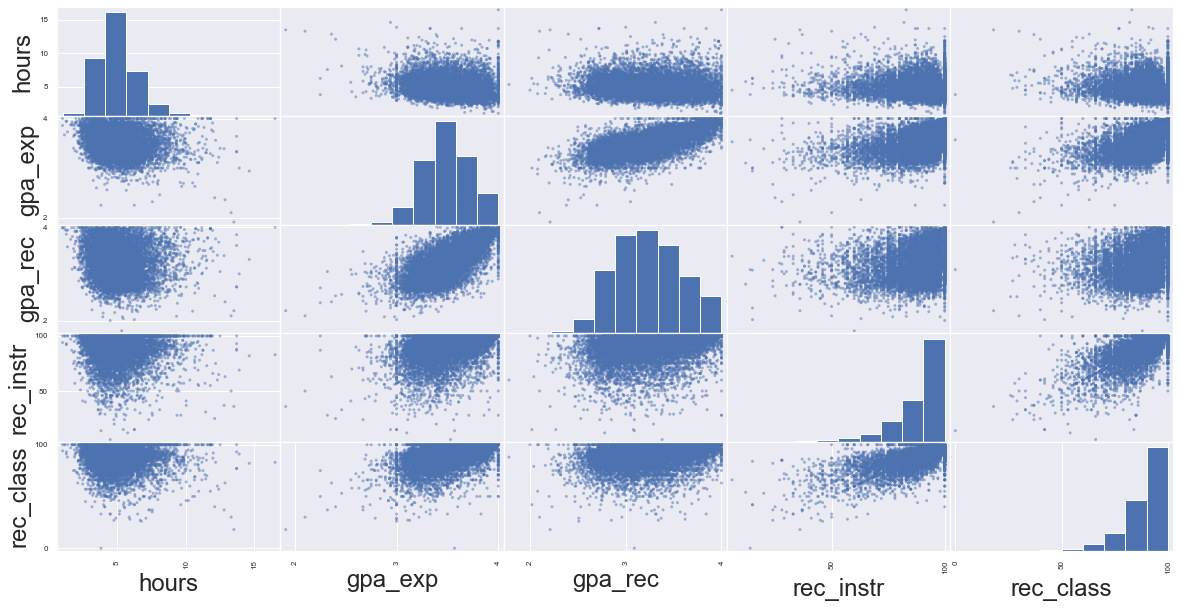

In [94]:
# generate a scatter matrix of social science professors
fig2 = pd.plotting.scatter_matrix(cape_social_sci[['hours','gpa_exp','gpa_rec','rec_instr','rec_class']], figsize=(20, 10))

Upon first comparison with the corresponding scatterplot for STEM classes, we can get a sense that the range of professor recommendation percentages given by students in Social Science courses are more clustered towards the higher end of the recommendation percentage scale; (the datapoints of the scatterplot for STEM classes were more varied on the y-axis). Taking this into account, we will explore how this may affect the relationship between class GPA and teacher recommendation percentages for Social Science classes and compare our results to those within the STEM and Humanities departments.

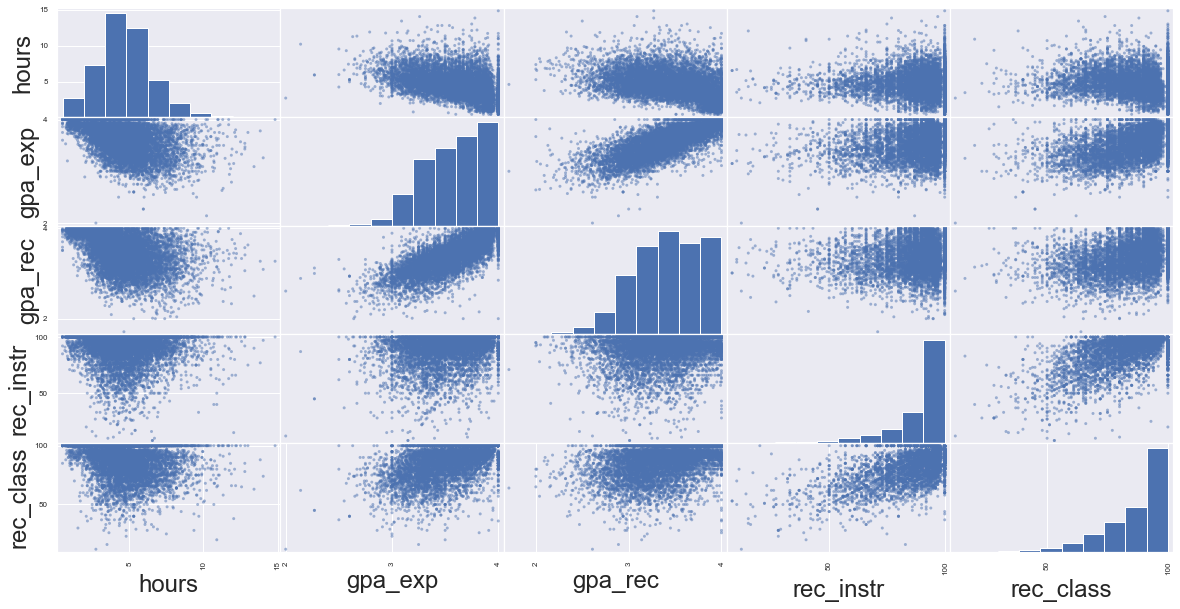

In [95]:
# generate a scatter matrix of humanities professors
fig3 = pd.plotting.scatter_matrix(cape_hum[['hours','gpa_exp','gpa_rec','rec_instr','rec_class']], figsize=(20, 10))

In the above scattermatrix, we see that the histogram for gpa_rec-- (a variable that is pertinent to our research question through its representation of course difficulty)-- is slightly skewed to the left. This indicates that unlike the distributions of average GPA for STEM and Social Science courses, students in Humanities courses tend to report a higher average GPA. Similar to the case with Social Science courses, in comparing this scatterplot with the corresponding scatterplot for STEM classes, we can get a sense that the range of instructor recommendation percentages for those taking Humanities courses are more clustered towards the higher end of the recommendation percentage scale. Taking this into account, we will explore how this may affect the relationship between class GPA and teacher recommendation percentages for Humanities classes and compare our results to those within the STEM and Social Science departments.

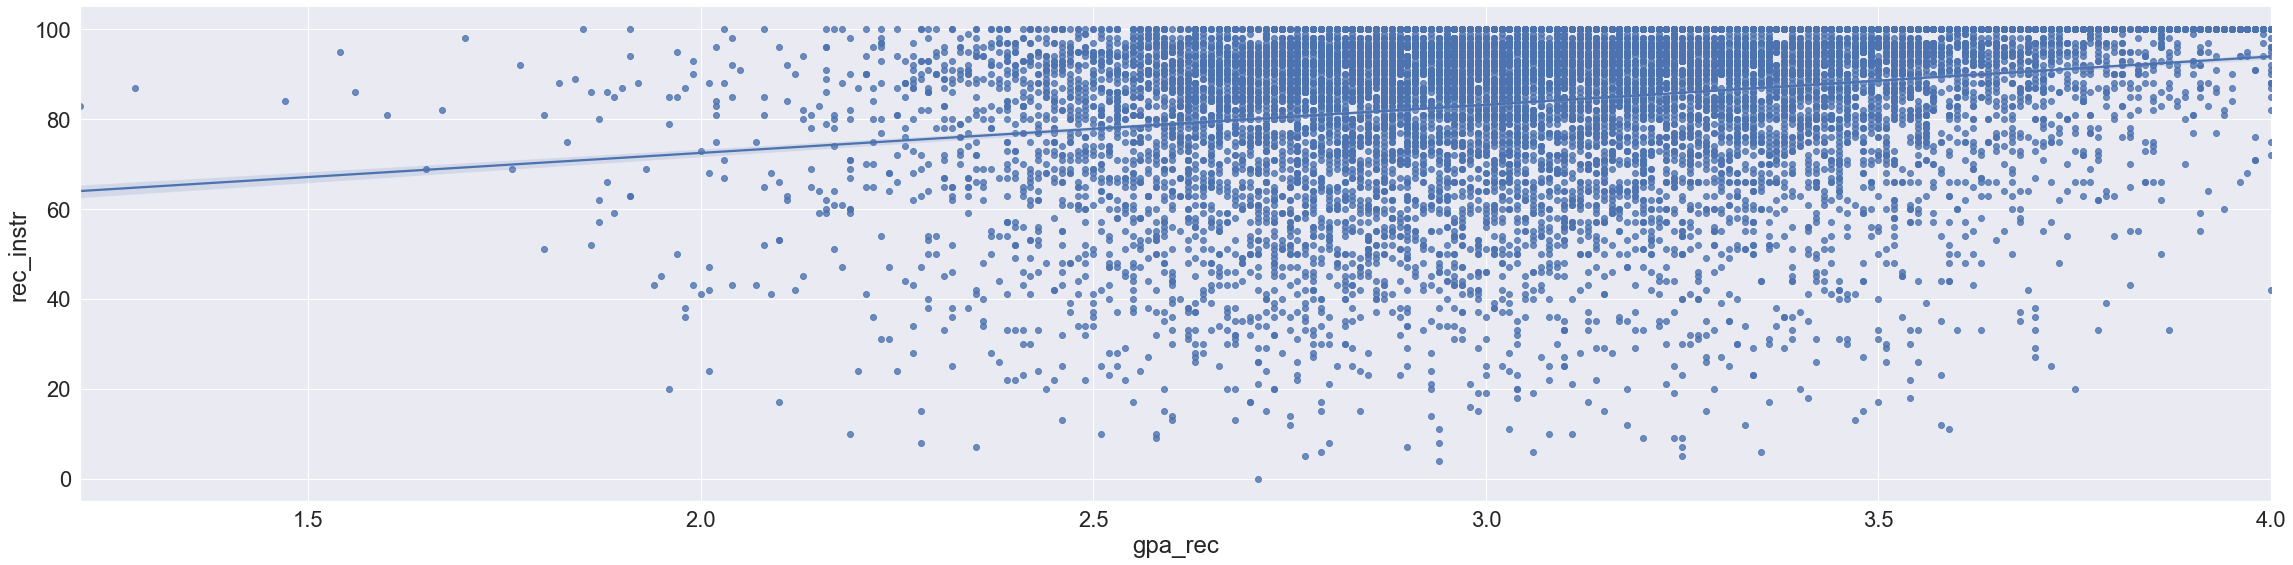

In [96]:
# Check the correlation between gpa_rec and rec_instr for STEM classes
plot1 = sns.lmplot(x='gpa_rec', y='rec_instr', data=cape_stem, fit_reg=True, height = 8, aspect = 4)

The figure above shows the correlation between the average gpa received by the students in STEM classes up against the percentage of those students who recommended that specific instructor who taught the STEM class. The figure shows a wide range when it comes to how many students recommended the instructor. The majority of instructors received over 20% recommendation rating. Also, the majority of the students received at least a 2.0 gpa or above.


In [97]:
# Construct and report a model that measures the relationship between gpa_rec & rec_instr
# for cape_stem
outcome1, predictor1 = patsy.dmatrices('rec_instr ~ gpa_rec', cape_stem)
model1 = sm.OLS(outcome1, predictor1)

results1 = model1.fit()

print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:              rec_instr   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     903.3
Date:                Thu, 25 Feb 2021   Prob (F-statistic):          2.49e-192
Time:                        15:43:15   Log-Likelihood:                -58488.
No. Observations:               13889   AIC:                         1.170e+05
Df Residuals:                   13887   BIC:                         1.170e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.0241      1.110     45.954      0.0

Looking at our OLS regression results for STEM classes we can see our best guess of what the intercept (our y intercept, beta 0) between our gpa received and instructor recommendation would be 51.28, and the standard error is 1.095, which indicates the majority of the data we have is clustered around our mean. Therefore, this indicates our coefficient intercept of 51.28 is very close to our true value.

If we look at our gpa received coefficient (beta 1, slope of the line) it suggests that as the gpa received increases the recommendation value for the instructor increases by 10.62.

Also, if you look at the standard error around the coefficient it is at 0.351, which means the error is moderate.

Finally, r-square value (6.1%) and the corresponding Pearson's r (0.25) seems to suggest that `gpa_rec` does not have a great explanatory power over `rec_instr` by itself.

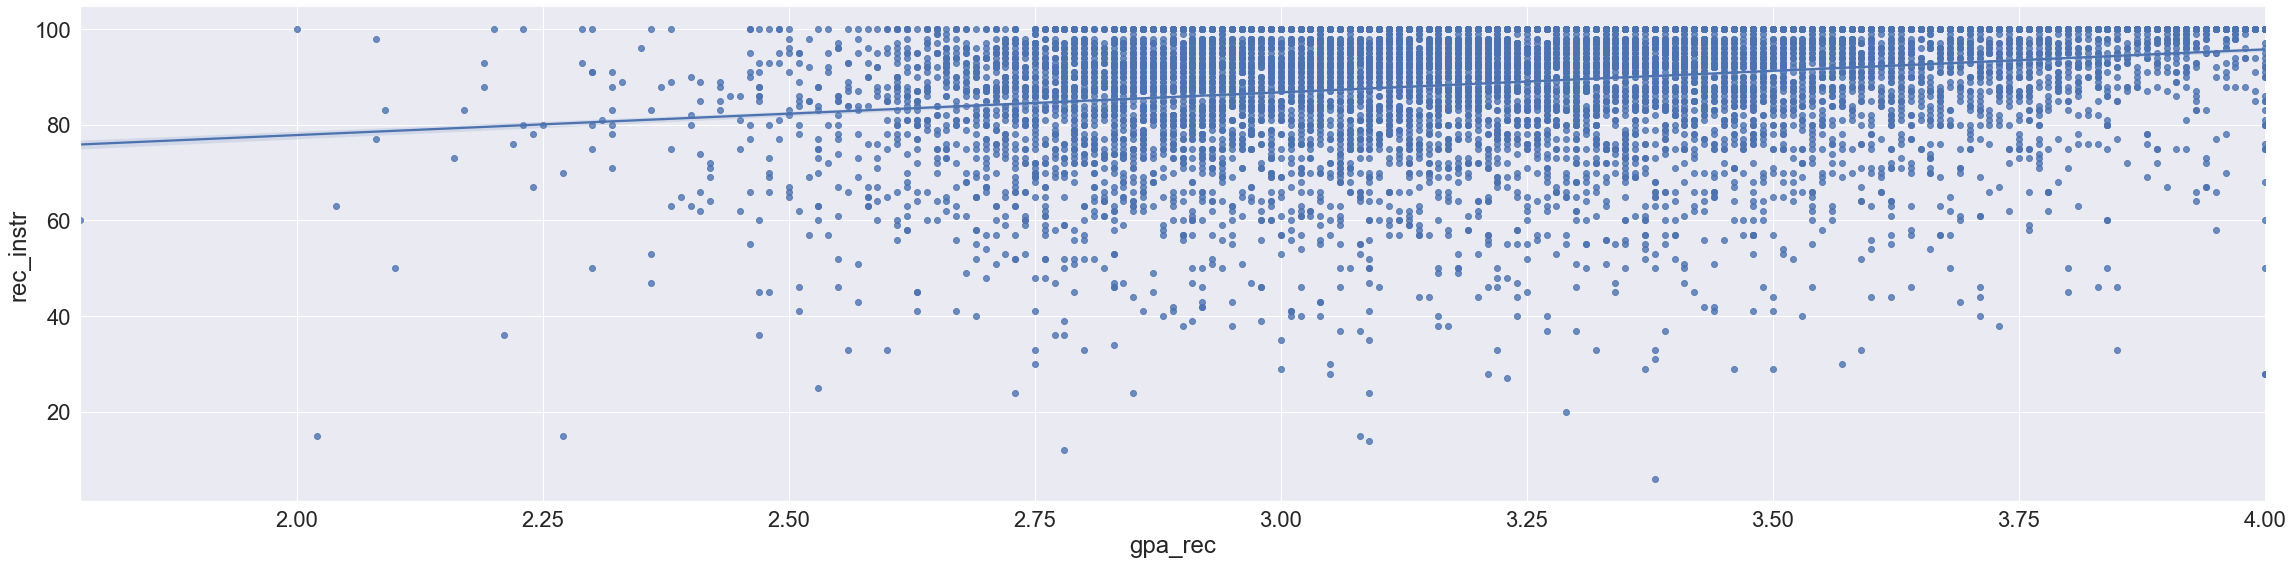

In [98]:
# Check the correlation between gpa_rec and rec_instr for social science classes
plot2 = sns.lmplot(x='gpa_rec', y='rec_instr', data=cape_social_sci, fit_reg=True, height = 8, aspect = 4)

The figure above shows the correlation between the average gpa received by the students in social science classes up against the percentage of those students who recommended that specific instructor who taught the social science class. It shows that the majority of instructors received approximately 60% or above recommendation value. Therefore, over half the students who took their class would recommend them to other students.

Also, the majority of the students received on average at least a 2.5 gpa or above. If we compare these numbers to the STEM figure that shows that instructors received over 20% recommendation rate, this highlights social sciences have a higher recommendation rate but similar gpa received by the students.

In [99]:
# Construct and report a model that measures the relationship between gpa_rec & rec_instr
# for cape_social_sci
outcome2, predictor2 = patsy.dmatrices('rec_instr ~ gpa_rec', cape_social_sci)
model2 = sm.OLS(outcome2, predictor2)

results2 = model2.fit()

print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:              rec_instr   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     804.3
Date:                Thu, 25 Feb 2021   Prob (F-statistic):          1.07e-170
Time:                        15:43:16   Log-Likelihood:                -41544.
No. Observations:               10749   AIC:                         8.309e+04
Df Residuals:                   10747   BIC:                         8.311e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.9502      1.029     58.280      0.0

Above is our OLS regression result for social science courses and instructors. If we compare these to the STEM regression results mentioned previously, we can see a slight increase for the (y) intercept, indicating a flater line.

If we look at our gpa received coefficient (beta 1, slope of the line) it suggests that as the gpa received increases the recommendation value for the instructor increases by 9.06. This figure is slightly smaller than the STEM figure of 10.62.

Again, the r-square value (7.0%) and the corresponding Pearson's r (0.26) suggests that `gpa_rec` does not have a great explanatory power over `rec_instr` by itself.

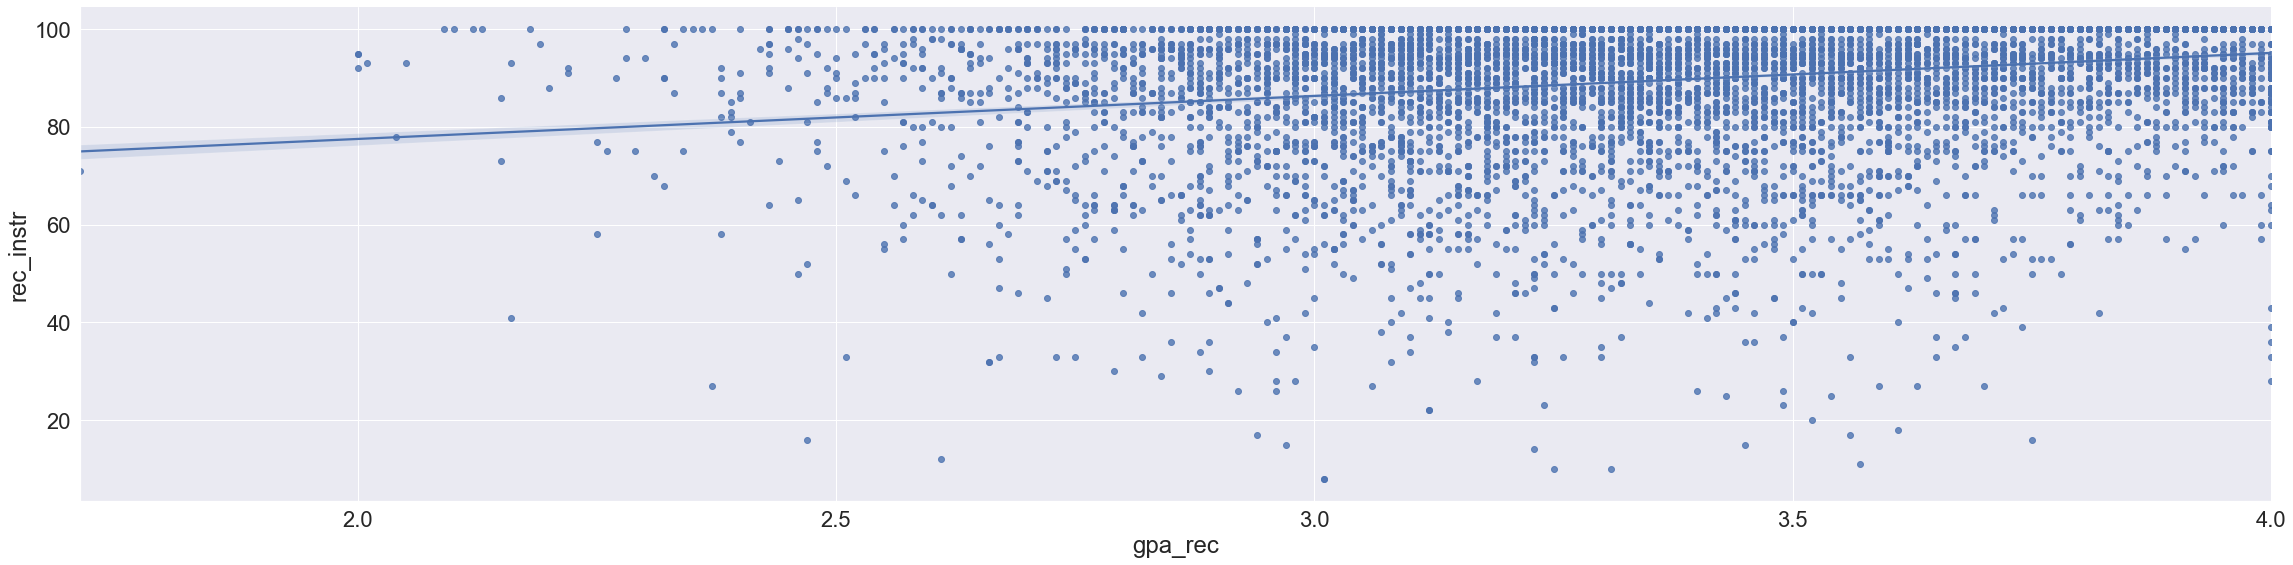

In [104]:
# Check the correlation between gpa_rec and rec_instr for humanities classes
plot3 = sns.lmplot(x='gpa_rec', y='rec_instr', data=cape_hum, fit_reg = True, height = 8, aspect = 4)

The figure above shows the correlation between the average gpa received by the students in humanity classes up against the percentage of those students who recommended that specific instructor who taught the humanity class. This figure shows that the majority of instructors received approximately 55% or above recommendation value. The majority of the students who took these classes received on average a 2.5 or above. Therefore, in comparison to social science classes, recommendation of instructors and gpa received is very similar. This can be seen in these figures as the patterns are almost identical. However, compared to STEM, humanities instructors have a higher recommendation rate. 

In [101]:
# Construct and report a model that measures the relationship between gpa_rec & rec_instr
# for cape_hum
outcome3, predictor3 = patsy.dmatrices('rec_instr ~ gpa_rec', cape_hum)
model3 = sm.OLS(outcome3, predictor3)

results3 = model3.fit()

print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:              rec_instr   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     569.6
Date:                Thu, 25 Feb 2021   Prob (F-statistic):          5.12e-122
Time:                        15:43:16   Log-Likelihood:                -34766.
No. Observations:                8760   AIC:                         6.954e+04
Df Residuals:                    8758   BIC:                         6.955e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.9364      1.268     47.269      0.0

The OLS regression results for humanity classes shows our best guess y intercept is at 57.3633 for our variables: gpa received and instructor recommendation. It shows the gapa received coefficient is 9.3271 which is nearly identical to social sciences classes with a coefficient of 9.06. It also has a similar standard error at 0.395 for humanity classes whereas for social sciences it is at 0.334.

Again, the r-square value (6.1%) and the corresponding Pearson's r (0.25) suggests that `gpa_rec` does not have a great explanatory power over `rec_instr` by itself.

We see from the scatter matrix that the shape of `rec_instr` and `re_class` graph seems to be more linear. We want to take closer look at that.

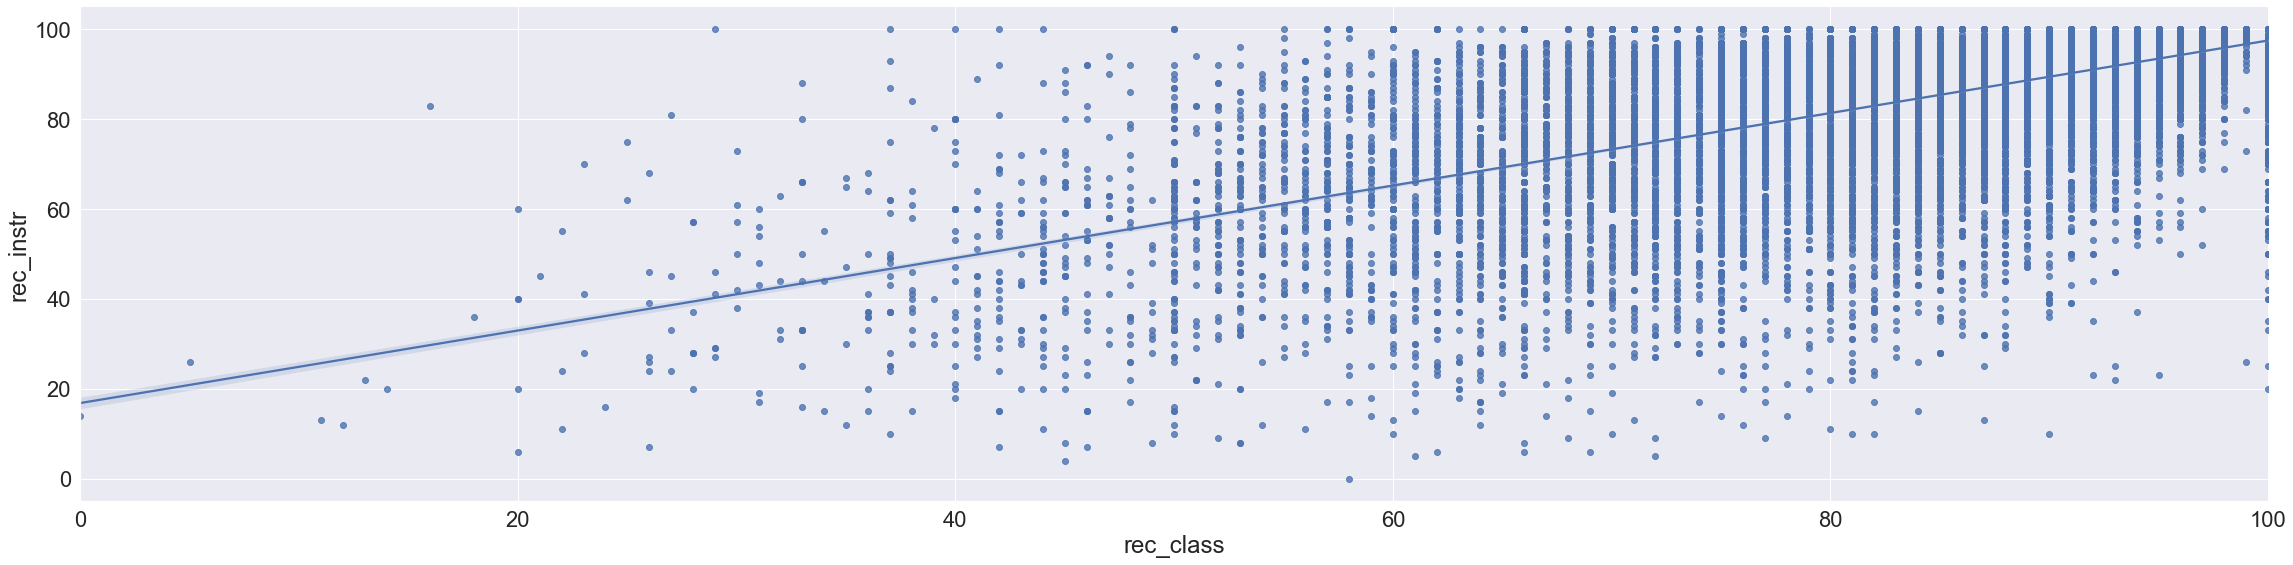

In [102]:
plot4 = sns.lmplot(x='rec_class', y='rec_instr', data=cape, fit_reg = True, height = 8, aspect = 4)

In [103]:
outcome_rec_instr_4, predictor_rec_class = patsy.dmatrices('rec_instr ~ rec_class', cape)

model4 = sm.OLS(outcome_rec_instr_4, predictor_rec_class)

results4 = model4.fit()

print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:              rec_instr   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                 2.609e+04
Date:                Thu, 25 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:43:18   Log-Likelihood:            -1.2757e+05
No. Observations:               33398   AIC:                         2.551e+05
Df Residuals:                   33396   BIC:                         2.552e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.8564      0.440     38.327      0.0

The result seems to show that in terms of correlation, __the Preason's r value between class recommendation and instructor recommendation is much higher than those of average gpa__. We may need to adjust our expectation accordingly.